![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Optimization for multiuser communications

We consider a multiple-input multiple-output (MIMO) communication system 
with $n$ transmitters and $n$ receivers. Each transmitter transmits with power $p_j$ and the 
gain from transmitter $j$ to receiver $i$ is $G_{ij}$. The signal power from transmitter $i$ to receiver $i$ is then

$$ S_i = G_{ii} p_i $$

and the interference is

$$ I_i = \sum_{j\neq i} G_{ij} p_j + \sigma_i $$

where $\sigma_i$ is an additive noise component. In this notebook we consider different strategies for optimizing the signal-to-inference-plus-noise ratio (SINR)

$$ s_i = \frac{G_{ii} p_i}{\sum_{j\neq i} G_{ij} p_j + \sigma_i} $$

with a bound on the total transmitted power $ \sum_i p_i \leq P $.

## Minimizing total power for given SINRs
Suppose we are given lower bounds $s_i \geq \gamma_i$. We can then minimize the required power
$$ 
\begin{array}{ll}
\text{minimize}   & \sum_i p_i \\
\text{subject to} & s_i \geq \gamma_i \\
                  & \sum_i p_i \leq P,
\end{array}
$$
which is equivalent to a linear optimization problem
$$ 
\begin{array}{ll}
\text{minimize}   & \sum_i p_i \\
\text{subject to} & G_{ii} p_i \geq \gamma_i\left ( \sum_{j\neq i} G_{ij} p_j + \sigma_i \right ) \\
                  & \sum_i p_i \leq P.
\end{array}
$$

## Maximizing the worst SINR
Alternatively we can maximize the smallest $s_i$,

$$
\begin{array}{ll}
\text{maximize}   & t \\
\text{subject to} & s_i \geq t \\
                  & \sum_i p_i \leq P.
\end{array}
$$

Equivalently we can minimize the inverse, 

$$
\begin{array}{ll}
\text{minimize}   & t^{-1} \\
\text{subject to} & t \left ( \sum_{j\neq i} G_{ij} p_j + \sigma_i \right ) G_{ii}^{-1} p_i^{-1} \leq 1 \\
                  & \sum_i p_i \leq P,
\end{array}
$$

which can be rewritten as a geometric programming problem

$$
\begin{array}{ll}
\text{minimize} & -z\\
\text{subject to} &
\log \left ( \sum_{j\neq i}e^{z + q_j - q_i + \log(G_{ij}/G_{ii})} + e^{z - q_i + \log(\sigma_i/G_{ii})} \right ) \leq 0\\
& \log \left ( \sum_i e^{q_i-\log P}\right) \leq 0
\end{array}
$$

with $p_i := e^{q_i}$ and $t := e^z$. To rewrite the geometric program into conic form, we note that

$$ 
\log \left( \sum_{i=1}^n e^{a_i^T x + b_i}\right) \leq 0 \qquad \Longleftrightarrow \qquad 
\sum_i u_i\leq 1, \quad (u_i, 1, a_i^Tx + b_i)\in K_\text{exp}, \: i=1,\dots n.
$$

In [1]:
import sys
import numpy as np
from mosek.fusion import *
import matplotlib.pyplot as plt

In [2]:
def logsumexp(M, A, x, b):    
    u = M.variable(A.shape[0])
    M.constraint( Expr.sum(u), Domain.lessThan(1.0))
    M.constraint( Expr.hstack(u,
                              Expr.constTerm(A.shape[0], 1.0),
                              Expr.add(Expr.mul(A, x), b)), Domain.inPExpCone())

In [3]:
def max_worst_sinr(G, P, sigma):
    n = G.shape[0]
    with Model('MAX_WORST_SINR') as M:
        qz = M.variable('qz', n+1) # concatenation of q and z
        M.objective('Objective',ObjectiveSense.Minimize,Expr.neg(qz.index(n)))
        for i in range(n):
            #u = M.variable(n)
            A = np.zeros((n,n+1))
            b = np.zeros(n)
            for j in [k for k in range(n) if k!=i]:
                A[j,[i,j,n]] = [-1, 1, 1]
                b[j] = G[i,j]/G[i,i]
            A[i, [i, n]] = [-1, 1]
            b[i] = sigma[i]/G[i,i]
            # If any Gij == 0, then we filter out row j
            idx = np.nonzero(b)[0] 
            logsumexp(M, A[idx,:], qz, np.log(b[idx]))
    
        logsumexp(M, np.eye(n), qz.slice(0,n), np.log(P)*np.ones(n))
        M.setLogHandler(sys.stdout)

        M.solve()
        pt = np.exp(qz.level())
        return (pt[0:n], pt[n])

In [4]:
P = 1.0
        
# G = np.array([[1.0,0.1,0.2],
#               [0.1,1.0,0.1],
#               [0.2,0.1,2.0]])

G = np.array([[1.0,0.1,0.2,0.1,0.0],
              [0.1,1.0,0.1,0.1,0.0],
              [0.2,0.1,2.0,0.2,0.2],
              [0.1,0.1,0.2,1.0,0.1],
              [0.0,0.0,0.2,0.1,1.0]])

sigma = 0.1*np.ones(G.shape[0])

In [5]:
p1, t1 = max_worst_sinr(G, P, sigma)

Problem
  Name                   : MAX_WORST_SINR  
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 84              
  Cones                  : 26              
  Scalar variables       : 110             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 1
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   : MAX_WORST_SINR  
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

In [6]:
print (p1, t1)

[0.21653447 0.19949097 0.15448378 0.23769449 0.19179628] 1.24006584063517


In [7]:
SINR1 = (np.diagonal(G)*p1)/(np.dot(G,p1) - np.diagonal(G)*p1 + sigma)
print(SINR1)

[1.24006585 1.24006586 1.24006586 1.24006585 1.24006586]


## Maximizing the best SINR
The solution to
$$
\begin{array}{ll}
\text{maximize}   & t_i \\
\text{subject to} & s_i \leq t_i \\
                  & \sum_i p_i \leq P
\end{array}
$$
is trivial; we choose the index $k$ maximizing $P_{ii}/\sigma_i$ and take $p_k=P$ and $p_j=0,\: j\neq k$.

In [8]:
def max_best_SINR(G,P,sigma):
    GSD = [G[i][i]/sigma[i] for i in range(G.shape[0])]
    P_max = max(GSD)
    #Thus, maximum of the best SINR is equal to...
    return(P_max*P)

In [9]:
print(max_best_SINR(G,P,sigma))

20.0


## Maximizing average SINR
We can maximize the average SINR as
$$
\begin{array}{ll}
\text{maximize}   & \sum_i t_i \\
\text{subject to} & s_i \geq t_i \\
                  & 0 \leq p_i \leq P_i \\
                  & \sum_i p_i \leq P,
\end{array}
$$
which corresponds to an intractable non-convex bilinear optimization problem. However, in the low-SINR regime, we can approximate the above problem by maximizing $\sum_i \log t_i$, or equivalently minimizing $\prod_i t_i^{-1}$:
$$
\begin{array}{ll}
\text{minimize}   & \prod_i t_i^{-1} \\
\text{subject to} & t_i \left ( \sum_{j\neq i} G_{ij} p_j + \sigma_i \right ) G_{ii}^{-1} p_i^{-1} \leq 1 \\
                  & 0 \leq p_i \leq P_i \\
                  & \sum_i p_i \leq P,
\end{array}
$$
which again corresponds to a geometric programming problem.

In [10]:
def min_Geo_mean(G,P,sigma):
    n = G.shape[0]
    with Model('MIN_GEO_MEAN') as M:
        t = M.variable('t',n)
        x = M.variable('x',n)
        q = M.variable('q',n)
            
        logsumexp(M,np.eye(n),q,np.log(P)*np.ones(n))
        
        M.constraint(Expr.hstack(x,Expr.constTerm(n, 1.0),Expr.neg(t)),Domain.inPExpCone())
        M.objective('Objective',ObjectiveSense.Minimize,Expr.sum(x))
        
        for i in range(n):
            A = np.zeros((n,n+1))
            b = np.zeros(n)
            for j in [k for k in range(n) if k!=i]:
                A[j,[i,j,n]] = [-1,1,1]
                b[j] = G[i,j]/G[i,i]
            A[i,[i,n]] = [-1,1]
            b[i] = sigma[i]/G[i,i]
            idx = np.nonzero(b)[0]
            logsumexp(M,A[idx,:],Expr.vstack(q,t.index(i)),np.log(b[idx]))
        
        M.setLogHandler(sys.stdout)
        
        M.solve()
        T = t.level()
        p = np.exp(q.level())
        return(T,p)

In [11]:
t2,p2 = min_Geo_mean(G, P, sigma)

Problem
  Name                   : MIN_GEO_MEAN    
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 99              
  Cones                  : 31              
  Scalar variables       : 134             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   : MIN_GEO_MEAN    
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

In [12]:
SINR2 = (np.diagonal(G)*p2)/(np.dot(G,p2) - np.diagonal(G)*p2 + sigma)
print('The powers for an optimum average would be: {}'.format(p2))
print('The corresponding SINRs: {}'.format(SINR2))

The powers for an optimum average would be: [0.21244427 0.21244413 0.15022304 0.21244423 0.21244434]
The corresponding SINRs: [1.23132227 1.3487561  1.2080129  1.09632857 1.40422832]


# Comparing the SINR for the cases above...

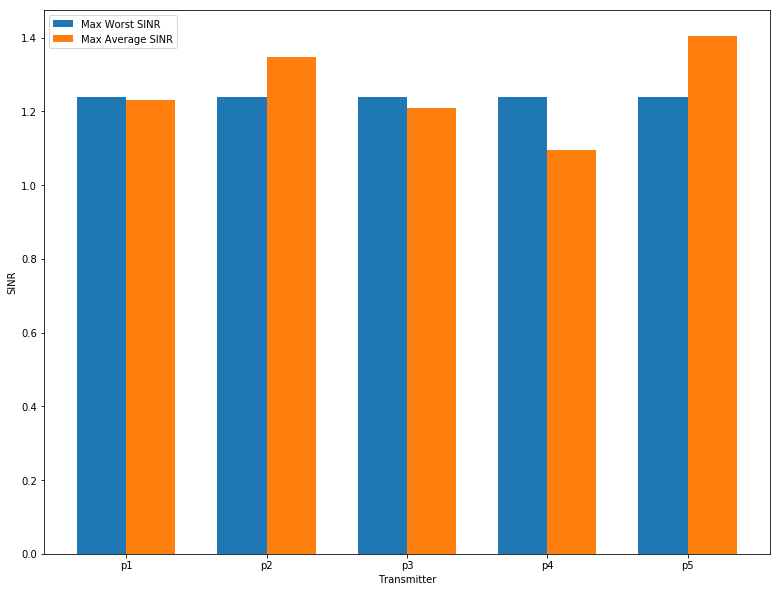

In [13]:
fig,ax = plt.subplots(figsize = (13,10))
bar_width = 0.35
p_num = np.arange(1,G.shape[0]+1)

B1 = ax.bar(p_num,SINR1,bar_width,label = 'Max Worst SINR')
B2 = ax.bar(p_num+bar_width,SINR2,bar_width,label = 'Max Average SINR')

ax.set_ylabel('SINR')
ax.set_xticks(p_num + bar_width/2)
x_tiK = ['p{}'.format(i+1) for i in range(G.shape[0])]
ax.set_xticklabels(x_tiK)
ax.set_xlabel('Transmitter')
ax.legend()
plt.show()

Note: The second case, that is the one with maximum best SINR is not plotted as it is just one transmitter (transmitter number 3) with a power of 1, and an SINR of 20.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 